In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Download files, set up folder, put files into folder

In [2]:
# training data: ./train.tsv
# test data:     ./test.tsv

In [2]:
filepath = './train.tsv'
dataframe = pd.read_csv(filepath, sep = '\t')
print('training data size:', len(dataframe))
print(dataframe)

training data size: 29996
       label                                             review
0          0  Leaks: Liss seems to be totally incompetent: m...
1          1  Replacement Peeler: Loved my old one. Loaned i...
2          0  Not what I was expecting: I chose to rate this...
3          1  Watch face is hard to read: Although I don't o...
4          0  Disappointing: I was eager to read this book s...
...      ...                                                ...
29991      1  Love EW: I must admit that I am a total TV afi...
29992      1  Easy to follow and delicious recipes!: I compl...
29993      1  The Beauty and Mystery of Veronique: Perhaps t...
29994      1  I love it.: Brilliant, hilarious, quick and ea...
29995      0  broken...: bad choice...2d film would not play...

[29996 rows x 2 columns]


# Count unigrams

In [3]:
# keep a counter of word frequency
counter = Counter()
for index, row in dataframe.iterrows():
    counter.update(row['review'].strip().lower().split())
print('Number of unique words:', len(counter))

# sort words by frequency from high to low
for word, count in sorted(counter.items(), key = lambda x: x[1], reverse = True)[:20]:
    print (word, count)

Number of unique words: 153396
the 117015
and 63290
a 60040
i 59790
to 57239
of 47056
this 41925
is 40356
it 39287
in 27000
for 25540
that 22153
was 19841
not 18893
you 17548
with 16919
but 16569
on 15657
have 15061
my 15027


# Document length distribution

In [4]:
# keep a list of document lengths (document length = # of tokens in review)
length_array = []
for index, row in dataframe.iterrows():
    length_array.append( len(row['review'].strip().lower().split()) )
print ('document length average:', np.mean(length_array))
print ('document length standard deviation:', np.std(length_array))

document length average: 78.49409921322842
document length standard deviation: 42.82795227790141


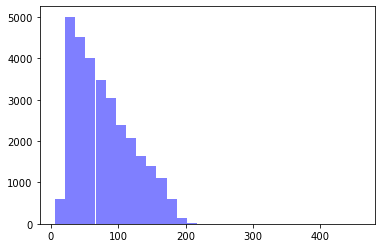

In [6]:
num_bins = 30
n, bins, patches = plt.hist(length_array, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Topic modeling

In [7]:
# adapted from: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [8]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/ray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# process a text string into a list of tokens

def prepare_text_for_lda(text):
    # convert all words into lower case, split by white space
    tokens = text.strip().lower().split()
    
    #  remove words with 1 or 2 letters (small words, punctuation)
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove English stopwords (as defined by NLTK)
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

In [10]:
# convert the corpus into a sparse matrix format for gensim

text_data = []
for index, row in dataframe.iterrows():
    review_text = prepare_text_for_lda(row['review'])
    text_data.append(review_text)
    
# print(text_data)
            
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# print(corpus)

In [16]:
# train latent Dirichlet topic model

NUM_TOPICS = 50
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30)

In [17]:
topics = ldamodel.print_topics(num_topics = NUM_TOPICS, num_words=6)
print ('Number of topics:', len(topics))
for topic in topics:
    print(topic)

Number of topics: 50
(0, '0.017*"remove" + 0.017*"manual" + 0.016*"fine." + 0.015*"workout" + 0.014*"pump" + 0.012*"cook"')
(1, '0.052*"beautiful" + 0.046*"voice" + 0.039*"track" + 0.027*"radio" + 0.020*"ms." + 0.019*"country"')
(2, '0.031*"lyrics" + 0.030*"tracks" + 0.028*"beat" + 0.017*"wall" + 0.017*"song," + 0.017*"holes"')
(3, '0.037*"baby" + 0.031*"food" + 0.023*"break" + 0.020*"cat" + 0.016*"eat" + 0.014*"followed"')
(4, '0.027*"keeps" + 0.026*"release" + 0.022*"dog" + 0.015*"dance" + 0.015*"heart" + 0.014*"fan,"')
(5, '0.019*"items" + 0.016*"volume" + 0.014*"asked" + 0.014*"packaging" + 0.012*"iron" + 0.012*"correct"')
(6, '0.023*"bible" + 0.021*"daily" + 0.016*"store." + 0.015*"3rd" + 0.014*"adventure" + 0.013*"stories."')
(7, '0.030*"toy" + 0.020*"they\'re" + 0.020*"feels" + 0.013*"okay" + 0.012*"cause" + 0.012*"mean"')
(8, '0.035*"boy" + 0.017*"boys" + 0.015*"mp3" + 0.015*"finds" + 0.014*"plot." + 0.013*"long."')
(9, '0.020*"book!" + 0.018*"learning" + 0.015*"class" + 0.013*

In [18]:
# predict topic distribution of a new document
new_doc = 'This action camera has superb battery life but its picture quality is somewhat poor.'
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
predicted_topics = ldamodel.get_document_topics(new_doc_bow)
print('topic distribution:\n', predicted_topics)

topic distribution:
 [(17, 0.20201175), (19, 0.11446888), (23, 0.08947453), (24, 0.101987064), (29, 0.18789904), (39, 0.10201461), (49, 0.116127454)]


# Label Distribution 

In [19]:
# keep a list of title lengths (title length = # of tokens in title)
counter = Counter()
for index, row in dataframe.iterrows():
    counter.update(str(row['label']))
print(counter)

Counter({'1': 15091, '0': 14905})


In [20]:
print('Positive label', counter['1']/sum(counter.values()))
print('Negative label', counter['0']/sum(counter.values()))

Positive label 0.5031004133884518
Negative label 0.4968995866115482
